## Passo 1 - Import de modulos

In [82]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier as LGBM1

## Passo 2 - Carga dos dados

In [83]:
# Carregue aqui o dataset
loans = pd.read_csv("..\data\loans.csv")
demogra = pd.read_csv("..\data\Demographics.csv")
accounts = pd.read_csv("..\data\Accounts.csv")
result = pd.read_csv("..\data\ANSWERS.csv")

In [84]:
lo_de = loans.merge(demogra)
lo_de = lo_de.dropna()
clean_df = lo_de.copy()

In [85]:
clean_df.INSTALLMENT_PLANS = clean_df.INSTALLMENT_PLANS.map({'NONE':0,'STORES':1,'BANK':2})
clean_df.OTHERS_ON_LOAN = clean_df.OTHERS_ON_LOAN.map({'NONE':0,'CO-APPLICANT':1,'GUARANTOR':2})
clean_df.SEX = clean_df.SEX.map({'M':0,'F':1})
clean_df.PROPERTY = clean_df.PROPERTY.map({'SAVINGS_INSURANCE':0,'CAR_OTHER':1,'REAL_ESTATE':2,'UNKNOWN':3})
clean_df.HOUSING = clean_df.HOUSING.map({'OWN':0,'RENT':1,'FREE':2})
clean_df.LOAN_PURPOSE = clean_df.LOAN_PURPOSE.map({'CAR_USED':0,'CAR_NEW':1,'APPLIANCES':2,'FURNITURE':3,'VACATION':4,'RADIO_TV':5,'OTHER':6,'REPAIRS':7,'RETRAINING':8,'EDUCATION':9,'BUSINESS':10})

In [86]:
clean_df['PAYMENT_TERM'] = pd.cut(x=clean_df['PAYMENT_TERM'], bins=[0, 200, 400, 600, 800, 1000, 1200, 1400,1600,1800,2000], labels=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18])
clean_df['LOAN_AMOUNT'] = pd.cut(x=clean_df['LOAN_AMOUNT'], bins=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [87]:
# accounts['EXISTE_CONTA'] = True
# clean_df = clean_df.merge(accounts, on='ID')
clean_df = clean_df.merge(accounts, on='ID', how='left')

In [88]:
clean_df.CHECKING_BALANCE = clean_df.CHECKING_BALANCE.fillna("NO_CHECKING")
clean_df.CHECKING_BALANCE = clean_df.CHECKING_BALANCE.apply(lambda x: '0' if x == 'NO_CHECKING' else x )
clean_df.CREDIT_HISTORY = clean_df.CREDIT_HISTORY.fillna("UNKNOWN")
clean_df.CREDIT_HISTORY = clean_df.CREDIT_HISTORY.map({'UNKNOWN':0,'NO_CREDITS':1,'OUTSTANDING_CREDIT':2,'PRIOR_PAYMENTS_DELAYED':3,'CREDITS_PAID_TO_DATE':4,'ALL_CREDITS_PAID_BACK':5})
clean_df.EXISTING_SAVINGS = clean_df.EXISTING_SAVINGS.fillna("UNKNOWN")
clean_df.EXISTING_SAVINGS = clean_df.EXISTING_SAVINGS.apply(lambda x: '0' if x == 'UNKNOWN' else x )
clean_df.EXISTING_CREDITS_COUNT = clean_df.EXISTING_CREDITS_COUNT.fillna(-1)
# clean_df.EXISTE_CONTA = clean_df.EXISTE_CONTA.fillna(False)

In [89]:
clean_df.CHECKING_BALANCE = clean_df.CHECKING_BALANCE.astype(float).round(0).astype(int)
clean_df.EXISTING_SAVINGS = clean_df.EXISTING_SAVINGS.astype(float).round(0).astype(int)

In [90]:
clean_df['CHECKING_BALANCE'] = pd.cut(x=clean_df['CHECKING_BALANCE'], bins=[-2800,-2100,-1400,-700,0,700,1400,2100,2800,3500,4200,4900,5600,6300,7000,7700,8400,9100,9800,10500,11200,11900,12600,13300,14000,14700,15400,16100,16800,17500,18200,18900,19600,20300,21000,21700,22400,23100,23800,24500,25200,25900,26600,27300,28000,28700], labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44])
clean_df['EXISTING_SAVINGS'] = pd.cut(x=clean_df['EXISTING_SAVINGS'], bins=[-1,0,1500,3000,4500,6000,7500,9000,10500,12000,13500,15000,16500,18000,19500,21000,22500,24000,25500,27000,28500,30000,31500,33000,34500,36000,37500,39000,40500,42000,43500,45000,46500,48000,49500,51000], labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34])

In [91]:
dataset = clean_df.copy()

## Passo 3 - Analise de Dados

In [ ]:
print(dataset.dtypes)
print(dataset.shape)
print(dataset.head())

In [ ]:
dataset.isnull().sum()

## Passo 4 - Pre processamento

In [92]:
# array = dataset.values
# X = array[:, 0:22].astype(float)
# Y = array[:, 22]
X = dataset.drop(['ALLOW'], axis=1).astype(int)
Y = dataset['ALLOW'].ravel().astype(int)
test_size = 0.30
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# y_train = Y_train.copy()
# y_test = Y_test.copy()

In [93]:
from imblearn.over_sampling import SMOTE as Smote
from imblearn.under_sampling import NearMiss

smt = Smote(random_state=seed)
X_train, Y_train = smt.fit_resample(X_train, Y_train)

## Passo 5 - Modelos de Classificacao

In [ ]:
X_train.info()

### 5.0.5 - Feature selection

In [67]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=7, step=1)
rfe = rfe.fit(X_train, Y_train)
print('Chosen best 5 feature by rfe:',X_train.columns[rfe.support_])

Chosen best 5 feature by rfe: Index(['ID', 'PAYMENT_TERM', 'LOAN_AMOUNT', 'AGE', 'EMPLOYMENT_DURATION',
       'CREDIT_HISTORY', 'EXISTING_SAVINGS'],
      dtype='object')


Accuracy is:  0.7401459854014598


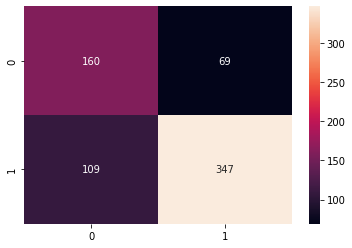

In [68]:
xtrain_5features = X_train[X_train.columns[rfe.support_]]
X_test_5features = X_test[X_train.columns[rfe.support_]]
#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(xtrain_5features,Y_train)
ac = accuracy_score(Y_test,clf_rf.predict(X_test_5features))
print('Accuracy is: ',ac)
cm = confusion_matrix(Y_test,clf_rf.predict(X_test_5features))
sns.heatmap(cm,annot=True,fmt="d")
plt.show()

In [69]:
from sklearn.feature_selection import RFECV
# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, Y_train)
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


Optimal number of features : 19
Best features : Index(['ID', 'PAYMENT_TERM', 'INSTALLMENT_PLANS', 'INSTALLMENT_PERCENT',
       'LOAN_PURPOSE', 'LOAN_AMOUNT', 'OTHERS_ON_LOAN', 'SEX', 'AGE',
       'JOB_TYPE', 'TELEPHONE', 'EMPLOYMENT_DURATION', 'PROPERTY', 'HOUSING',
       'CURRENT_RESIDENCE_DURATION', 'CHECKING_BALANCE', 'CREDIT_HISTORY',
       'EXISTING_SAVINGS', 'EXISTING_CREDITS_COUNT'],
      dtype='object')


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


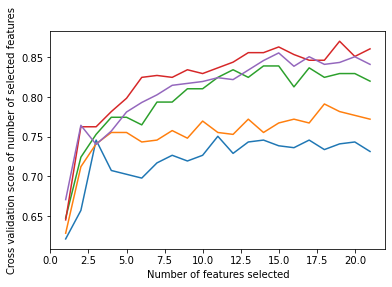

In [70]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [71]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X_train,Y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clr_rf_5.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 5 (0.136217)
2. feature 1 (0.119916)
3. feature 8 (0.105170)
4. feature 13 (0.085480)
5. feature 18 (0.082826)
6. feature 19 (0.076738)
7. feature 0 (0.063339)
8. feature 17 (0.050029)
9. feature 4 (0.041805)
10. feature 16 (0.036975)
11. feature 14 (0.033500)
12. feature 2 (0.033322)
13. feature 3 (0.033099)
14. feature 20 (0.019638)
15. feature 9 (0.016944)
16. feature 15 (0.015013)
17. feature 7 (0.013443)
18. feature 11 (0.011995)
19. feature 6 (0.011490)
20. feature 10 (0.010469)
21. feature 12 (0.002593)


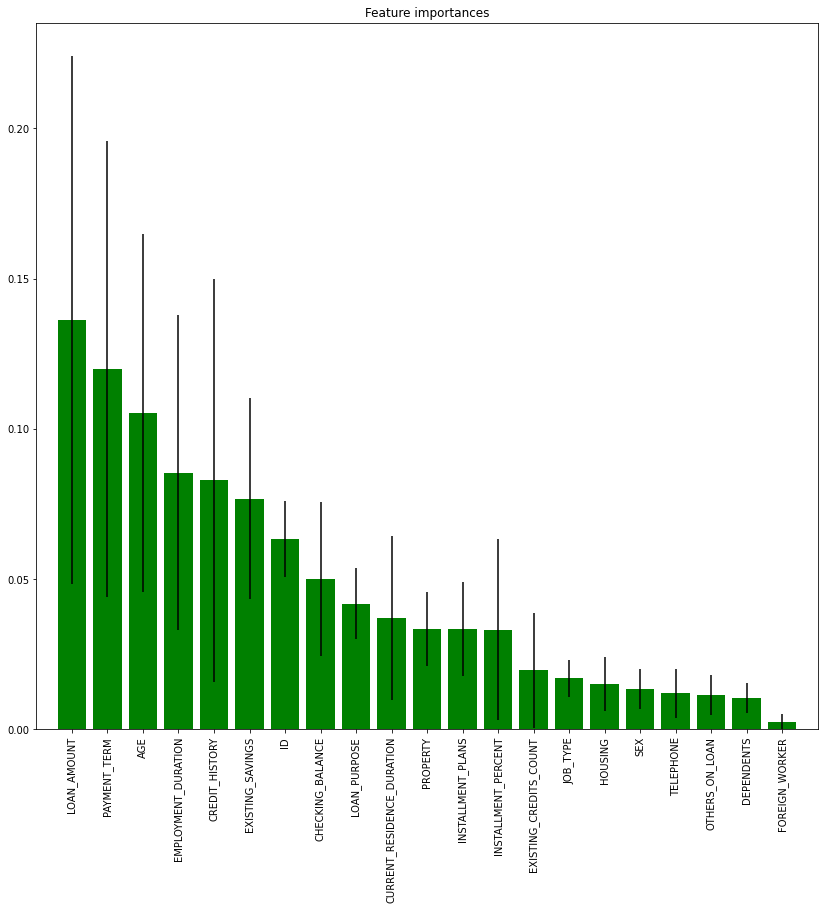

In [72]:
# Plot the feature importances of the forest
plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],  color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Text(0, 0.5, 'Variance Ratio Explained')

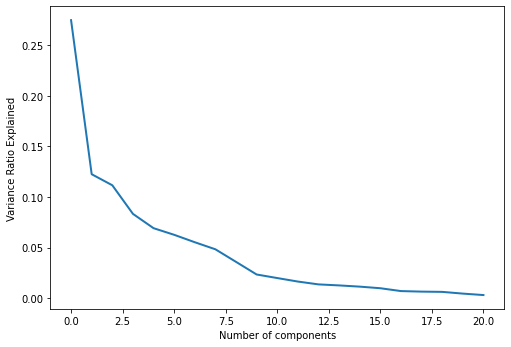

In [73]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
#normalization
x_train_N = (x_train-x_train.mean())/(x_train.max()-x_train.min())
x_test_N = (x_test-x_test.mean())/(x_test.max()-x_test.min())
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train_N)
plt.figure(1, figsize=(9, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Variance Ratio Explained')

### Passo 5.1 — Criação e avaliação de modelos: linha base

In [94]:
# Parâmetros
num_folds = 10
scoring = 'accuracy'

In [95]:
# Criação dos modelos
models = []
models.append(('LR', LogisticRegression(solver='newton-cg')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RFC', RandomForestClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('XGBC', XGBClassifier()))
models.append(('LGBM1', LGBM1()))

In [96]:
# definindo uma semente global
np.random.seed(7) 

# Avaliação dos modelos
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f'{name, cv_results.mean(), cv_results.std()}')

C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz

('LR', 0.7637298438466857, 0.029889021480960093)
('KNN', 0.5790621701306737, 0.023757109726734338)
('CART', 0.7157845885050778, 0.03978382675978988)
('NB', 0.6816137662432207, 0.06590736942509222)
('SVM', 0.32613293051359515, 0.17255558845191768)
('RFC', 0.8093273395697593, 0.07132026455860133)
('GBC', 0.7993630109562115, 0.06302792176351892)
[20:13:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with

[20:13:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
('XGBC', 0.8196001528773704, 0.07854192552789659)
('LGBM1', 0.8162714301314018, 0.06958529693511054)


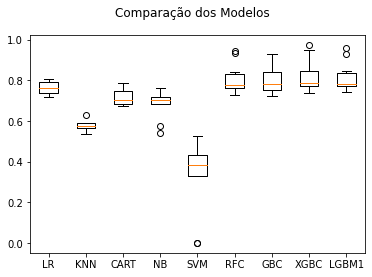

In [97]:
# Comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Passo 5.2 — Criação e avaliação de modelos: dados padronizados

In [98]:
# definindo uma semente global
np.random.seed(7) 

# Padronização do dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression(solver='newton-cg'))])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))
pipelines.append(('ScaledRFC', Pipeline([('Scaler', StandardScaler()),('RFC', RandomForestClassifier())])))
pipelines.append(('ScaledGBC', Pipeline([('Scaler', StandardScaler()),('GBC', GradientBoostingClassifier())])))
pipelines.append(('ScaledXBC', Pipeline([('Scaler', StandardScaler()),('XBC', XGBClassifier())])))
pipelines.append(('ScaledLGBM1', Pipeline([('Scaler', StandardScaler()),('LGBM1', LGBM1())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f'{name, cv_results.mean(), cv_results.std()}')

('ScaledLR', 0.7637298438466857, 0.029889021480960093)
('ScaledKNN', 0.7574072725949114, 0.03414527104934262)
('ScaledCART', 0.7163924580497216, 0.04426853279103338)
('ScaledNB', 0.7120836821606669, 0.057040697210521435)
('ScaledSVM', 0.793621919702981, 0.046595444092568536)
('ScaledRFC', 0.809025224766134, 0.07149013349612912)
('ScaledGBC', 0.799665125759837, 0.06340131733932834)
[20:14:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with

[20:14:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
('ScaledXBC', 0.8196001528773704, 0.07854192552789659)
('ScaledLGBM1', 0.8183898736941725, 0.07181322418086698)


Resultados - sem SMOTE

('ScaledLR', 0.78300395256917, 0.02600598284521105)

('ScaledKNN', 0.7600790513833993, 0.0332603470140892)

('ScaledCART', 0.7086956521739131, 0.030156315510217337)

('ScaledNB', 0.7581027667984189, 0.034448630149408584)

('ScaledSVM', 0.7924901185770751, 0.03168225205905414)

('ScaledRFC', 0.783794466403162, 0.028229757052441254)

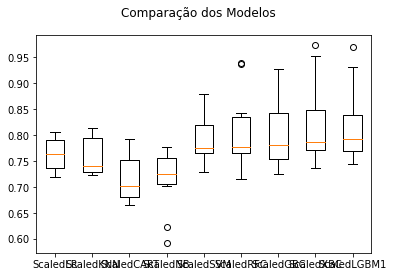

In [99]:
# Comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Passo 5.3 — Ajuste dos modelos

#### Passo 5.3.1 — Ajuste do KNN

In [21]:
# Tuning do KNN
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
distancias = ['euclidean', 'manhattan', 'minkowski']
param_grid = dict(n_neighbors=k, metric=distancias)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print(f'Melhor: {grid_result.best_score_} usando {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'{mean} ({stdev}): {param}')

Melhor: 0.8283596622138099 usando {'metric': 'euclidean', 'n_neighbors': 1}
0.8283596622138099 (0.08759350304690376): {'metric': 'euclidean', 'n_neighbors': 1}
0.7869954136788848 (0.061364841890312535): {'metric': 'euclidean', 'n_neighbors': 3}
0.7815646270884141 (0.05581122026407608): {'metric': 'euclidean', 'n_neighbors': 5}
0.7806555527244932 (0.04892872582921086): {'metric': 'euclidean', 'n_neighbors': 7}
0.7746178065737269 (0.05095154424041414): {'metric': 'euclidean', 'n_neighbors': 9}
0.7682797655880318 (0.053719441202940484): {'metric': 'euclidean', 'n_neighbors': 11}
0.7691833800458632 (0.04956750540948026): {'metric': 'euclidean', 'n_neighbors': 13}
0.7667673716012084 (0.04970170490441769): {'metric': 'euclidean', 'n_neighbors': 15}
0.768584610344702 (0.052697913773227696): {'metric': 'euclidean', 'n_neighbors': 17}
0.769182470061515 (0.055935186437282736): {'metric': 'euclidean', 'n_neighbors': 19}
0.7673706912241108 (0.051954062020976584): {'metric': 'euclidean', 'n_neighbo

Melhor: 0.7992094861660078 usando {'metric': 'manhattan', 'n_neighbors': 21} - sem SMOTE

Melhor: 0.8223146361882575 usando {'metric': 'euclidean', 'n_neighbors': 1} - com SMOTE

#### Passo 5.3.2 — Ajuste do SVM

In [22]:
# Tuning do SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.5, 1.0, 1.5, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print(f'Melhor: {grid_result.best_score_} usando {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'{mean} ({stdev}): {param}')

Melhor: 0.8165517053106687 usando {'C': 2.0, 'kernel': 'rbf'}
0.7522385614967423 (0.024440244700125017): {'C': 0.1, 'kernel': 'linear'}
0.6936546791395188 (0.09414848420544591): {'C': 0.1, 'kernel': 'poly'}
0.7600980963127434 (0.021393331433543373): {'C': 0.1, 'kernel': 'rbf'}
0.7449978160375641 (0.027220323965986025): {'C': 0.1, 'kernel': 'sigmoid'}
0.7522394714810905 (0.023480943648618642): {'C': 0.5, 'kernel': 'linear'}
0.7537573253740036 (0.029583903665049507): {'C': 0.5, 'kernel': 'poly'}
0.7824309321879663 (0.027947654191909095): {'C': 0.5, 'kernel': 'rbf'}
0.7009509336439413 (0.03406424388792938): {'C': 0.5, 'kernel': 'sigmoid'}
0.7534470207112437 (0.02388251722050316): {'C': 1.0, 'kernel': 'linear'}
0.7706730244239799 (0.04016007641948245): {'C': 1.0, 'kernel': 'poly'}
0.7978324172824228 (0.03798242408042777): {'C': 1.0, 'kernel': 'rbf'}
0.6867751974666036 (0.03497614980409784): {'C': 1.0, 'kernel': 'sigmoid'}
0.7528437010883412 (0.023667463897900774): {'C': 1.5, 'kernel': 'lin

Melhor: 0.7936758893280633 usando {'C': 1.5, 'kernel': 'rbf'} - sem SMOTE

Melhor: 0.8138381319841299 usando {'C': 2.0, 'kernel': 'rbf'} - com SMOTE

#### Passo 5.3.3 — Ajuste do RFC

In [34]:
# Tuning do RFC
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [1000]
max_depth = [14, 18, 22, 26]
criterion = ['entropy','gini']
min_samples_leaf = [1, 2, 3]
max_features = ['auto', 'log2']
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, 
                  criterion=criterion, max_features=max_features, min_samples_leaf=min_samples_leaf)
model = RandomForestClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=12)
grid_result = grid.fit(rescaledX, Y_train)
print(f'Melhor: {grid_result.best_score_} usando {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'{mean} ({stdev}): {param}')

Melhor: 0.8422278236814325 usando {'criterion': 'entropy', 'max_depth': 18, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.8395124303861973 (0.08769588728176195): {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 1000}
0.8328759145342699 (0.08752137679344543): {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.8322698649583227 (0.08251678951016127): {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 1000}
0.8386079059440178 (0.08823684177669938): {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 1000}
0.8358916026644341 (0.08527774264516813): {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.8346831434499327 (0.08144581889160975): {'criterion': 'entropy', 'max_depth': 14, 'max_f

Melhor: 0.7909090909090909 usando {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 200} - sem SMOTE
Demorou 9 min!

Melhor: 0.8352846431041385 usando {'criterion': 'entropy', 'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 800} - com SMOTE

Melhor: 0.8410175444982346 usando {'criterion': 'entropy', 'max_depth': 22, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 1000} - com SMOTE

Melhor: 0.8416263240272267 usando {'criterion': 'gini', 'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 1000} - com SMOTE

#### Passo 5.3.4 — Ajuste do GBC

In [ ]:
# Tuning do GBC
# n_estimators = [1200]
# max_depth = [9, 11, 15]
# criterion = ['entropy']
# min_samples_leaf = [1, 2, 3]
# max_features = ['auto', 'log2']
# param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, 
#                   criterion=criterion, max_features=max_features, min_samples_leaf=min_samples_leaf)
# model = GradientBoostingClassifier()
# kfold = KFold(n_splits=num_folds)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=12)
# grid_result = grid.fit(rescaledX, Y_train)
# print(f'Melhor: {grid_result.best_score_} usando {grid_result.best_params_}')
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print(f'{mean} ({stdev}): {param}')

#### Passo 5.3.5 — Ajuste do LGBM

In [ ]:
# Tuning do LGBM
# n_estimators = [1200]
# max_depth = [9, 11, 15]
# criterion = ['entropy']
# min_samples_leaf = [1, 2, 3]
# max_features = ['auto', 'log2']
# param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, 
#                   criterion=criterion, max_features=max_features, min_samples_leaf=min_samples_leaf)
# model = RandomForestClassifier()
# kfold = KFold(n_splits=num_folds)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=12)
# grid_result = grid.fit(rescaledX, Y_train)
# print(f'Melhor: {grid_result.best_score_} usando {grid_result.best_params_}')
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print(f'{mean} ({stdev}): {param}')

## Passo 6 — Finalização do Modelo

A ideia aqui é testar o melhor modelo com todos os dados de treinamento

Accuracy score = 0.7870967741935484


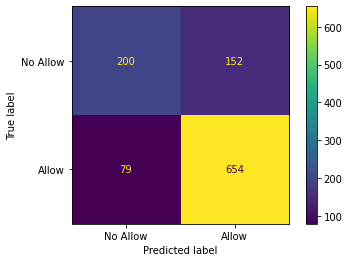

              precision    recall  f1-score   support

    No Allow       0.72      0.57      0.63       352
       Allow       0.81      0.89      0.85       733

    accuracy                           0.79      1085
   macro avg       0.76      0.73      0.74      1085
weighted avg       0.78      0.79      0.78      1085



In [36]:
# Preparação do modelo RFC
# model = RandomForestClassifier(n_estimators=1000, max_depth=33, criterion='entropy', max_features='auto', min_samples_leaf=1)
model = RandomForestClassifier(n_estimators=1000, min_samples_leaf=2, max_features='auto',
                            n_jobs=11, criterion='entropy', max_depth=18)
model.fit(X_train, Y_train)

# Estimativa da acurácia no conjunto de teste
predictions = model.predict(X_test)
print(f'Accuracy score = {accuracy_score(Y_test, predictions)}')

# Matriz de confusão
cm = confusion_matrix(Y_test, predictions)
labels = ['No Allow', 'Allow']
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(values_format='d')
plt.show()
print(classification_report(Y_test, predictions, target_names=labels))

C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz

Accuracy score = 0.7483870967741936


C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a362014\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz

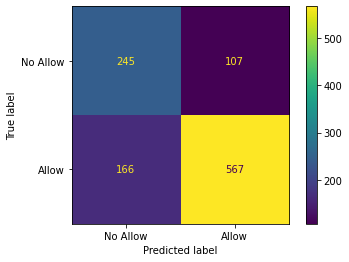

              precision    recall  f1-score   support

    No Allow       0.60      0.70      0.64       352
       Allow       0.84      0.77      0.81       733

    accuracy                           0.75      1085
   macro avg       0.72      0.73      0.72      1085
weighted avg       0.76      0.75      0.75      1085



In [446]:
# Preparação do modelo LR
model = LogisticRegression(solver='newton-cg')
model.fit(X_train, Y_train)

# Estimativa da acurácia no conjunto de teste
predictions = model.predict(X_test)
print(f'Accuracy score = {accuracy_score(Y_test, predictions)}')

# Matriz de confusão
cm = confusion_matrix(Y_test, predictions)
labels = ['No Allow', 'Allow']
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(values_format='d')
plt.show()
print(classification_report(Y_test, predictions, target_names=labels))

# Deu Accuracy score = 0.7880184331797235 - sem SMOTE

In [12]:
X = clean_df.drop(['ALLOW'], axis=1)
y = clean_df['ALLOW'].ravel()

In [13]:
test_pct = 0.3 # Separaremos 30% dos dados para testes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_pct, random_state=42, stratify=y)

In [14]:
from imblearn.over_sampling import SMOTE as Smote
from imblearn.under_sampling import NearMiss

# smt = NearMiss()
# X_train, y_train = smt.fit_resample(X_train, y_train)

# smt = Smote(sampling_strategy='auto', k_neighbors=8, random_state=42)
smt = Smote(random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)

In [18]:
model = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features="log2",
                            random_state=42, n_jobs=11, criterion='gini')
# model = LogisticRegression(solver='lbfgs', max_iter=4000)

# model = DecisionTreeClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo (número de predições assertivas sobre número total de testes): {acc}")

Acurácia do modelo (número de predições assertivas sobre número total de testes): 0.7788018433179723


In [20]:
acc_cv = cross_val_score(model,X_train, y_train,cv=10)
print(f"Acurácia do modelo (com cross validate): {acc_cv.mean()}")

# np.sqrt(mean_squared_error(y_test, y_pred))

Acurácia do modelo (com cross validate): 0.8246751273572258


In [21]:
print(f'{classification_report(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.69      0.64      0.66       368
           1       0.82      0.85      0.84       717

    accuracy                           0.78      1085
   macro avg       0.75      0.75      0.75      1085
weighted avg       0.78      0.78      0.78      1085

